## Calculating return period for cyclones in Madagascar


Using La Reunion forecasts

In [7]:
import os
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.datasources import codab, rsmc

In [8]:
df = rsmc.load_historical_forecast_distances()
distance_cols = [x for x in df.columns if "_distance_km" in x]
df["any_distance_km"] = df[distance_cols].min(axis=1)

In [9]:
df["name"].unique()

array(['0120102011', 'ALENGA', 'ANAIS', '0120132014', 'ADJALI',
       'ANNABELLE', 'ABELA', 'AVA', '0120182019', '0120192020', 'ALICIA',
       'ANA', 'ASHLEY', 'ALVARO', 'ABELE', '0220112012', '0220122013',
       'AMARA', '0220142015', 'BOHALE', 'BRANSBY', 'IRVING', 'ALCIDE',
       'BELNA', '0220202021', 'BATSIRAI', 'BALITA', 'BELAL', '0320112012',
       'BOLDWIN', 'BRUCE', 'BAKUNG', 'CORENTIN', '0320162017',
       'BERGUITTA', 'BOUCHRA', 'AMBALI', 'BONGOYO', 'CLIFF', '0320222023',
       'CANDICE', '0420102011', 'BENILDE', 'CLAUDIA', 'BEJISA', 'KATE',
       'DAYA', 'CARLOS', '0420172018', 'KENANGA', 'CALVINIA', 'CHALANE',
       'DUMAKO', 'DARIAN', 'ANGGREK', 'BINGIZA', 'CHANDA', 'DUMILE',
       '0520132014', 'BANSI', 'URIAH', 'DINEO', 'CEBILE', 'CILIDA',
       '0520192020', '0520202021', 'EMNATI', 'CHENESO', '0520232024',
       '0620102011', 'DANDO', 'EMANG', 'COLIN', 'CHEDZA', 'EMERAUDE',
       'ENAWO', 'DUMAZILE', 'DESMOND', 'DIANE', 'DANILO', 'FEZILE',
       'DINGANI',

In [10]:
distance_thresh = 0
wind_threshs = [48, 64, 90, 115]

dicts = []
for max_lt in range(0, 121, 12):
    for wind_thresh in wind_threshs:
        rp = rsmc.calculate_rp(
            df,
            pcode="any",
            max_lt=max_lt,
            distance_thresh=distance_thresh,
            wind_thresh=wind_thresh,
        )
        dicts.append(
            {
                "wind_thresh": wind_thresh,
                "max_lt": max_lt,
                "rp": rp,
            }
        )
df_rps = pd.DataFrame(dicts)

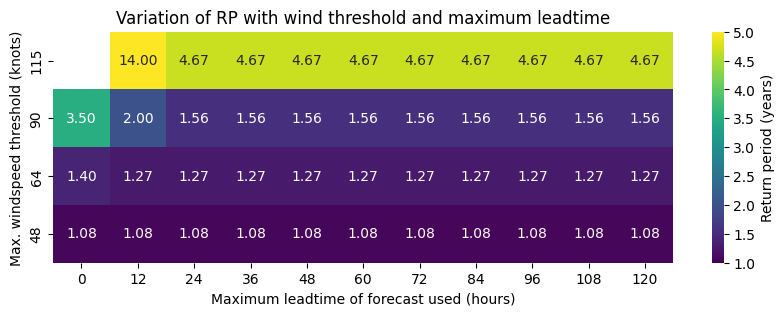

In [11]:
heatmap_data = df_rps.pivot(index="wind_thresh", columns="max_lt", values="rp")

fig, ax = plt.subplots(figsize=(10, 3))

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    ax=ax,
    vmax=5,
    vmin=1,
    cmap="viridis",
    cbar_kws={"label": "Return period (years)"},
)

ax.set_xlabel("Maximum leadtime of forecast used (hours)")
ax.set_ylabel("Max. windspeed threshold (knots)")
ax.set_title(
    "Variation of RP with wind threshold and maximum leadtime"
)
ax.invert_yaxis()

plt.show()